# Image Quality Metrics: PSNR and SSIM

This notebook explains two key metrics for evaluating super-resolution quality.

---

## PSNR (Peak Signal-to-Noise Ratio)

Measures pixel-wise reconstruction accuracy.

**Formula:**
$$\text{PSNR} = 20 \cdot \log_{10}\left(\frac{\text{MAX}}{\sqrt{\text{MSE}}}\right)$$

where MSE = Mean Squared Error between images.

**Interpretation:**
- Unit: Decibels (dB)
- Higher = better
- Typical SR range: 25-40 dB
- Limitation: Poor correlation with human perception

---

## SSIM (Structural Similarity Index)

Measures structural similarity considering luminance, contrast, and structure.

**Formula:**
$$\text{SSIM}(x, y) = \frac{(2\mu_x\mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}$$

**Interpretation:**
- Range: 0 to 1
- Closer to 1 = better
- Typical SR range: 0.90-0.99
- Better correlation with human perception than PSNR

---

In [43]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


In [44]:
# Load dataset
hr_dir = Path('./dataset/high_resolution')
lr_dir = Path('./dataset/low_resolution')

hr_images = sorted(list(hr_dir.glob('*.png')))
lr_images = sorted(list(lr_dir.glob('*.png')))

# Randomly select 5 samples
indices = random.sample(range(len(hr_images)), 5)
transform = transforms.ToTensor()

samples = []
for idx in indices:
    hr_img = Image.open(hr_images[idx]).convert('RGB')
    lr_img = Image.open(lr_images[idx]).convert('RGB')
    lr_img = lr_img.resize((256, 256), Image.BICUBIC)  # Upsample to 256x256
    
    samples.append({
        'lr': np.array(lr_img) / 255.0,
        'hr': np.array(hr_img) / 255.0
    })

print(f'Loaded 5 random samples')

Loaded 5 random samples


In [45]:
# Load U-Net model
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3):
        super().__init__()
        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.up1 = Up(256 + 128, 128)
        self.up2 = Up(128 + 64, 64)
        self.up3 = Up(64 + 32, 32)
        self.outc = nn.Conv2d(32, n_classes, kernel_size=1)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        return self.outc(x)

model = UNet().to(device)
checkpoint = torch.load('./checkpoints/best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f'✓ Model loaded (epoch {checkpoint["epoch"]+1})')

✓ Model loaded (epoch 29)


In [46]:
# Generate super-resolved images
with torch.no_grad():
    for sample in samples:
        lr_tensor = torch.from_numpy(sample['lr'].transpose(2, 0, 1)).float().unsqueeze(0).to(device)
        sr_tensor = model(lr_tensor).squeeze(0).cpu()
        sample['sr'] = np.clip(sr_tensor.numpy().transpose(1, 2, 0), 0, 1)

print('✓ Generated SR images')

✓ Generated SR images


In [47]:
# Calculate metrics
for i, sample in enumerate(samples):
    # LR vs HR (baseline: bicubic)
    sample['psnr_lr'] = psnr(sample['hr'], sample['lr'], data_range=1.0)
    sample['ssim_lr'] = ssim(sample['hr'], sample['lr'], data_range=1.0, channel_axis=2)
    
    # SR vs HR (model)
    sample['psnr_sr'] = psnr(sample['hr'], sample['sr'], data_range=1.0)
    sample['ssim_sr'] = ssim(sample['hr'], sample['sr'], data_range=1.0, channel_axis=2)
    
    print(f'Sample {i+1}:')
    print(f'  Bicubic - PSNR: {sample["psnr_lr"]:.2f} dB, SSIM: {sample["ssim_lr"]:.4f}')
    print(f'  U-Net   - PSNR: {sample["psnr_sr"]:.2f} dB, SSIM: {sample["ssim_sr"]:.4f}')
    print(f'  Gain    - PSNR: +{sample["psnr_sr"] - sample["psnr_lr"]:.2f} dB, SSIM: +{sample["ssim_sr"] - sample["ssim_lr"]:.4f}\n')

Sample 1:
  Bicubic - PSNR: 27.15 dB, SSIM: 0.9492
  U-Net   - PSNR: 29.50 dB, SSIM: 0.9832
  Gain    - PSNR: +2.35 dB, SSIM: +0.0340

Sample 2:
  Bicubic - PSNR: 26.94 dB, SSIM: 0.9524
  U-Net   - PSNR: 25.98 dB, SSIM: 0.9758
  Gain    - PSNR: +-0.96 dB, SSIM: +0.0234

Sample 3:
  Bicubic - PSNR: 27.43 dB, SSIM: 0.9595
  U-Net   - PSNR: 31.72 dB, SSIM: 0.9887
  Gain    - PSNR: +4.29 dB, SSIM: +0.0292

Sample 4:
  Bicubic - PSNR: 26.75 dB, SSIM: 0.9530
  U-Net   - PSNR: 27.48 dB, SSIM: 0.9734
  Gain    - PSNR: +0.74 dB, SSIM: +0.0204

Sample 5:
  Bicubic - PSNR: 28.56 dB, SSIM: 0.9586
  U-Net   - PSNR: 35.25 dB, SSIM: 0.9919
  Gain    - PSNR: +6.69 dB, SSIM: +0.0333



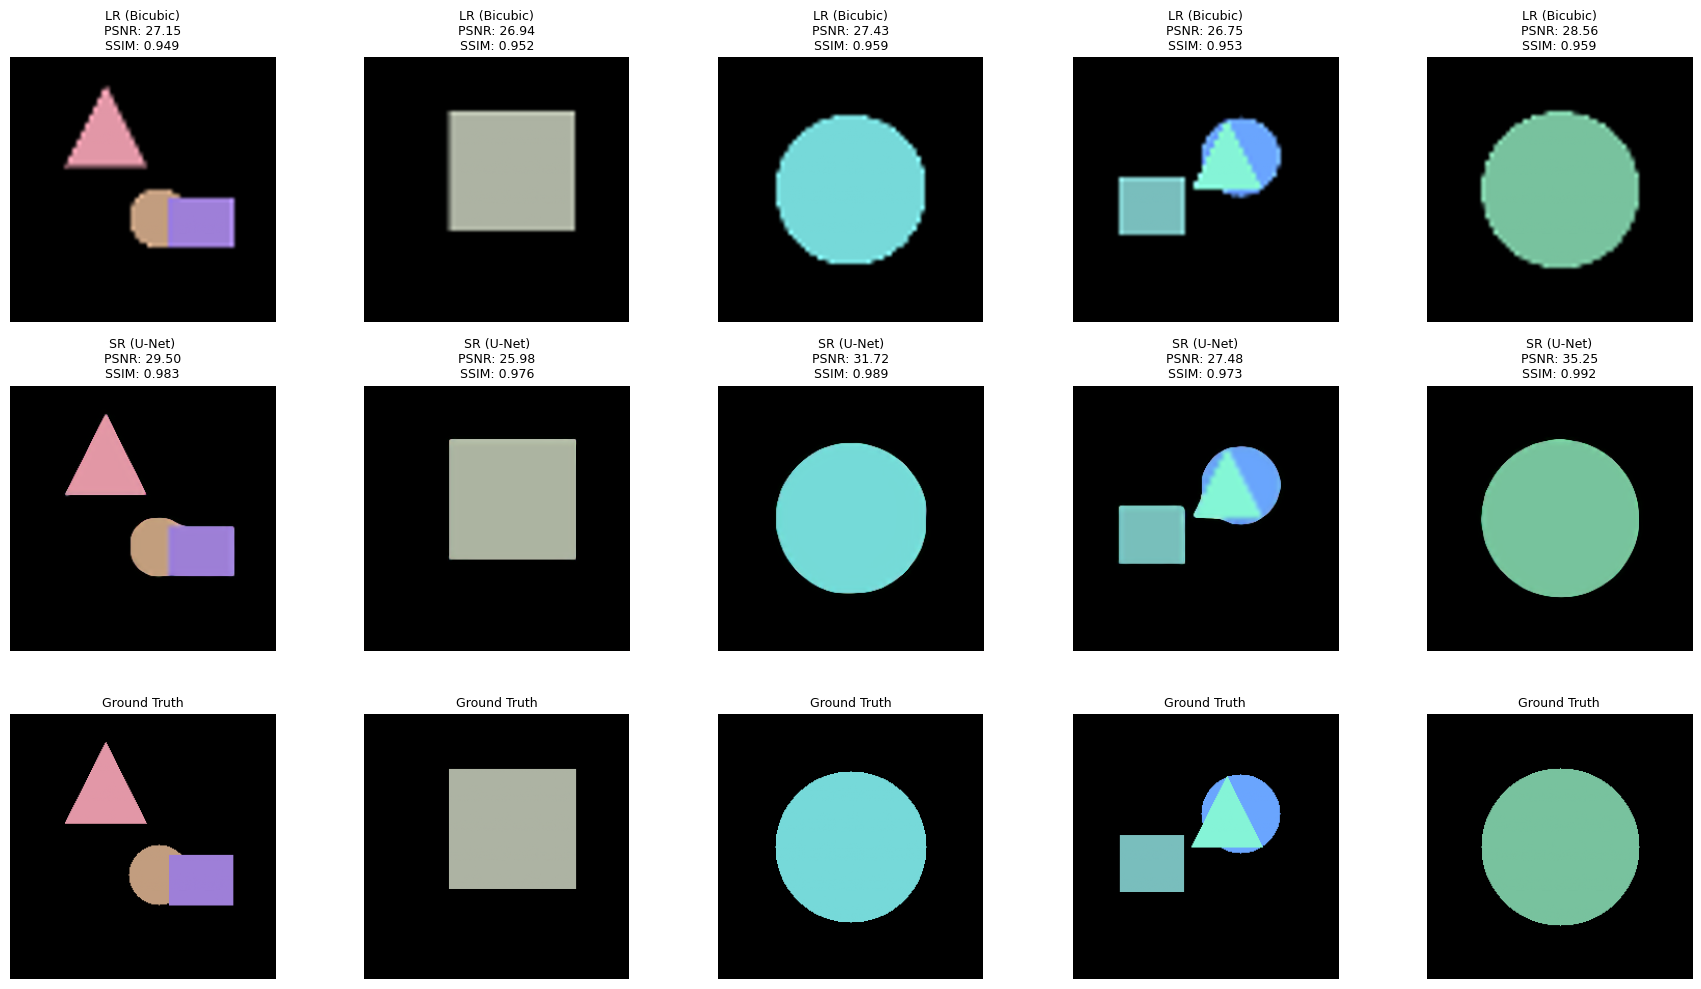

Saved: metrics_comparison.png


In [48]:
# Visualize comparison
fig, axes = plt.subplots(3, 5, figsize=(18, 10))

for i, sample in enumerate(samples):
    # Row 1: LR (Bicubic)
    axes[0, i].imshow(sample['lr'])
    axes[0, i].set_title(f'LR (Bicubic)\nPSNR: {sample["psnr_lr"]:.2f}\nSSIM: {sample["ssim_lr"]:.3f}', fontsize=9)
    axes[0, i].axis('off')
    
    # Row 2: SR (U-Net)
    axes[1, i].imshow(sample['sr'])
    axes[1, i].set_title(f'SR (U-Net)\nPSNR: {sample["psnr_sr"]:.2f}\nSSIM: {sample["ssim_sr"]:.3f}', fontsize=9)
    axes[1, i].axis('off')
    
    # Row 3: HR (Ground Truth)
    axes[2, i].imshow(sample['hr'])
    axes[2, i].set_title('Ground Truth', fontsize=9)
    axes[2, i].axis('off')

plt.tight_layout()
plt.savefig('./metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('Saved: metrics_comparison.png')

---

## What Happens When Images Don't Match?

To demonstrate the importance of these metrics, let's compare **two completely different images** (mismatched pairs). This shows what happens when reconstruction fails.

In [49]:
# Load two different random images (mismatched pairs)
mismatched_indices = random.sample(range(len(hr_images)), 4)

mismatch_samples = []

# Pair 1: Image A's LR/SR vs Image B's HR
idx_a, idx_b = mismatched_indices[0], mismatched_indices[1]
hr_a = Image.open(hr_images[idx_a]).convert('RGB')
lr_a = Image.open(lr_images[idx_a]).convert('RGB').resize((256, 256), Image.BICUBIC)
hr_b = Image.open(hr_images[idx_b]).convert('RGB')

lr_a_np = np.array(lr_a) / 255.0
hr_a_np = np.array(hr_a) / 255.0
hr_b_np = np.array(hr_b) / 255.0

# Generate SR for image A
with torch.no_grad():
    lr_tensor = torch.from_numpy(lr_a_np.transpose(2, 0, 1)).float().unsqueeze(0).to(device)
    sr_tensor = model(lr_tensor).squeeze(0).cpu()
    sr_a_np = np.clip(sr_tensor.numpy().transpose(1, 2, 0), 0, 1)

# Calculate metrics: comparing image A's outputs with image B's HR (WRONG!)
psnr_mismatch_lr = psnr(hr_b_np, lr_a_np, data_range=1.0)
ssim_mismatch_lr = ssim(hr_b_np, lr_a_np, data_range=1.0, channel_axis=2)
psnr_mismatch_sr = psnr(hr_b_np, sr_a_np, data_range=1.0)
ssim_mismatch_sr = ssim(hr_b_np, sr_a_np, data_range=1.0, channel_axis=2)

mismatch_samples.append({
    'lr': lr_a_np,
    'sr': sr_a_np,
    'hr': hr_b_np,  # Different image!
    'psnr_lr': psnr_mismatch_lr,
    'ssim_lr': ssim_mismatch_lr,
    'psnr_sr': psnr_mismatch_sr,
    'ssim_sr': ssim_mismatch_sr
})

# Pair 2: Another mismatched pair
idx_c, idx_d = mismatched_indices[2], mismatched_indices[3]
hr_c = Image.open(hr_images[idx_c]).convert('RGB')
lr_c = Image.open(lr_images[idx_c]).convert('RGB').resize((256, 256), Image.BICUBIC)
hr_d = Image.open(hr_images[idx_d]).convert('RGB')

lr_c_np = np.array(lr_c) / 255.0
hr_c_np = np.array(hr_c) / 255.0
hr_d_np = np.array(hr_d) / 255.0

with torch.no_grad():
    lr_tensor = torch.from_numpy(lr_c_np.transpose(2, 0, 1)).float().unsqueeze(0).to(device)
    sr_tensor = model(lr_tensor).squeeze(0).cpu()
    sr_c_np = np.clip(sr_tensor.numpy().transpose(1, 2, 0), 0, 1)

psnr_mismatch_lr2 = psnr(hr_d_np, lr_c_np, data_range=1.0)
ssim_mismatch_lr2 = ssim(hr_d_np, lr_c_np, data_range=1.0, channel_axis=2)
psnr_mismatch_sr2 = psnr(hr_d_np, sr_c_np, data_range=1.0)
ssim_mismatch_sr2 = ssim(hr_d_np, sr_c_np, data_range=1.0, channel_axis=2)

mismatch_samples.append({
    'lr': lr_c_np,
    'sr': sr_c_np,
    'hr': hr_d_np,
    'psnr_lr': psnr_mismatch_lr2,
    'ssim_lr': ssim_mismatch_lr2,
    'psnr_sr': psnr_mismatch_sr2,
    'ssim_sr': ssim_mismatch_sr2
})

print('Mismatched Pair 1:')
print(f'  LR (Image A) vs HR (Image B) - PSNR: {psnr_mismatch_lr:.2f} dB, SSIM: {ssim_mismatch_lr:.4f}')
print(f'  SR (Image A) vs HR (Image B) - PSNR: {psnr_mismatch_sr:.2f} dB, SSIM: {ssim_mismatch_sr:.4f}')
print(f'\nMismatched Pair 2:')
print(f'  LR (Image C) vs HR (Image D) - PSNR: {psnr_mismatch_lr2:.2f} dB, SSIM: {ssim_mismatch_lr2:.4f}')
print(f'  SR (Image C) vs HR (Image D) - PSNR: {psnr_mismatch_sr2:.2f} dB, SSIM: {ssim_mismatch_sr2:.4f}')
print(f'\n⚠️ Notice: Much lower PSNR and SSIM values!')

Mismatched Pair 1:
  LR (Image A) vs HR (Image B) - PSNR: 15.21 dB, SSIM: 0.8946
  SR (Image A) vs HR (Image B) - PSNR: 15.09 dB, SSIM: 0.9023

Mismatched Pair 2:
  LR (Image C) vs HR (Image D) - PSNR: 8.22 dB, SSIM: 0.6965
  SR (Image C) vs HR (Image D) - PSNR: 8.15 dB, SSIM: 0.7084

⚠️ Notice: Much lower PSNR and SSIM values!


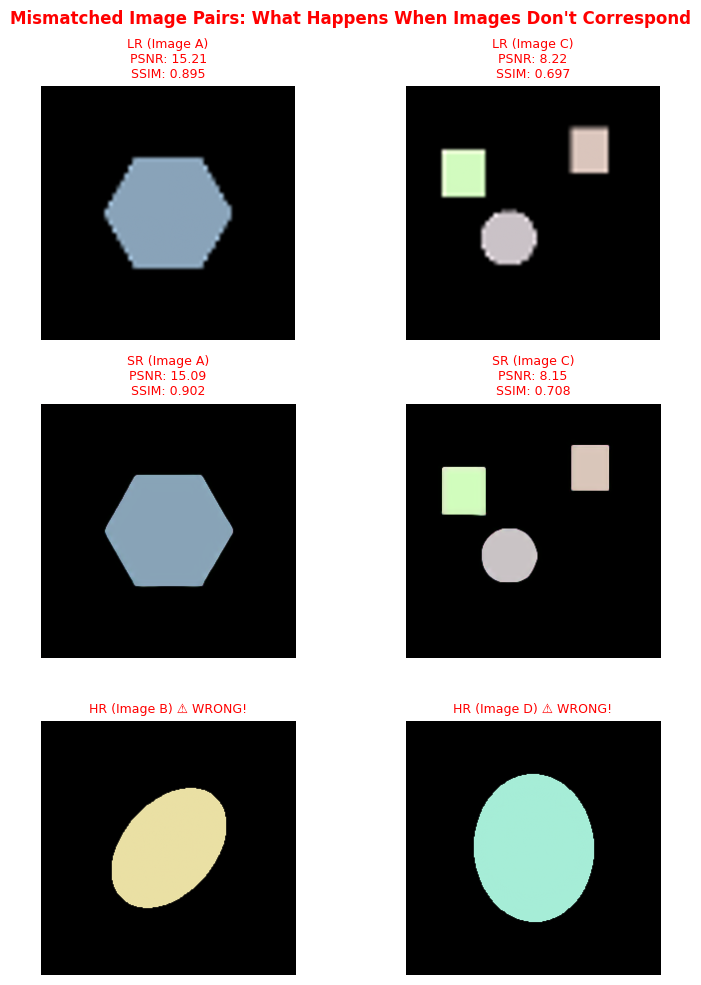

Saved: metrics_mismatch.png

Key Observation:
When comparing DIFFERENT images:
  - PSNR drops significantly (typically < 20 dB)
  - SSIM drops significantly (typically < 0.8)
  - Both metrics correctly identify the mismatch!


In [50]:
# Visualize mismatched pairs
fig, axes = plt.subplots(3, 2, figsize=(8, 10))

for i, sample in enumerate(mismatch_samples):
    # Row 1: LR (from one image)
    axes[0, i].imshow(sample['lr'])
    axes[0, i].set_title(f'LR (Image {chr(65+i*2)})\nPSNR: {sample["psnr_lr"]:.2f}\nSSIM: {sample["ssim_lr"]:.3f}', fontsize=9, color='red')
    axes[0, i].axis('off')
    
    # Row 2: SR (from same image as LR)
    axes[1, i].imshow(sample['sr'])
    axes[1, i].set_title(f'SR (Image {chr(65+i*2)})\nPSNR: {sample["psnr_sr"]:.2f}\nSSIM: {sample["ssim_sr"]:.3f}', fontsize=9, color='red')
    axes[1, i].axis('off')
    
    # Row 3: HR (from DIFFERENT image!)
    axes[2, i].imshow(sample['hr'])
    axes[2, i].set_title(f'HR (Image {chr(66+i*2)}) ⚠️ WRONG!', fontsize=9, color='red')
    axes[2, i].axis('off')

plt.suptitle('Mismatched Image Pairs: What Happens When Images Don\'t Correspond', fontsize=12, fontweight='bold', color='red')
plt.tight_layout()
plt.savefig('./metrics_mismatch.png', dpi=150, bbox_inches='tight')
plt.show()

print('Saved: metrics_mismatch.png')
print('\n' + '='*60)
print('Key Observation:')
print('='*60)
print('When comparing DIFFERENT images:')
print('  - PSNR drops significantly (typically < 20 dB)')
print('  - SSIM drops significantly (typically < 0.8)')
print('  - Both metrics correctly identify the mismatch!')
print('='*60)